In [1]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


***reading a random file***

In [2]:
import pickle 

In [3]:
file_path = "/kaggle/input/wesad-full-dataset/WESAD/S2/S2.pkl"

with open(file_path, "rb") as file:
    s2 = pickle.load(file, encoding="latin1")

print(s2)

{'signal': {'chest': {'ACC': array([[ 0.95539999, -0.222     , -0.55799997],
       [ 0.92579997, -0.2216    , -0.55379999],
       [ 0.90820003, -0.21960002, -0.53920001],
       ...,
       [ 0.87179995, -0.12379998, -0.30419999],
       [ 0.87300003, -0.12339997, -0.30260003],
       [ 0.87020004, -0.12199998, -0.30220002]]), 'ECG': array([[ 0.02142334],
       [ 0.02032471],
       [ 0.01652527],
       ...,
       [-0.00544739],
       [ 0.00013733],
       [ 0.0040741 ]]), 'EMG': array([[-0.00444031],
       [ 0.00434875],
       [ 0.00517273],
       ...,
       [-0.01716614],
       [-0.02897644],
       [-0.02357483]]), 'EDA': array([[5.25054932],
       [5.26733398],
       [5.24330139],
       ...,
       [0.36048889],
       [0.36582947],
       [0.365448  ]]), 'Temp': array([[30.120758],
       [30.129517],
       [30.138214],
       ...,
       [31.459229],
       [31.484283],
       [31.456268]], dtype=float32), 'Resp': array([[-1.14898682],
       [-1.12457275],
       

**reading the whole patient 2 and constructing its data frame**

In [4]:
import os
import pickle
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

# ===============================
# PARAMETERS & PATHS
# ===============================
# Path to your WESAD dataset folder 
DATA_PATH = "/kaggle/input/wesad-full-dataset/WESAD"

# For testing, we will organize the data for one subject only
subject = "S2"

# Sampling info: 700 readings per second
# For example, using a 60-seconds window:
time_window_second = 60
samples_per_second = 700
window_size = int(samples_per_second * time_window_second)  # e.g., ~42000 samples
step_size = window_size  # No overlap

# ===============================
# HELPER FUNCTIONS
# ===============================
def map_labels(labels):
    """
    Map original WESAD labels to binary values:
      - Non-Stress: labels in [1, 3, 4] → 0
      - Stress:     labels in [2, 5, 6, 7] → 1
      - Any other value is considered undefined (set to -1)
    """
    mapped = np.full_like(labels, fill_value=-1)
    mapped[np.isin(labels, [1, 3, 4])] = 0
    mapped[np.isin(labels, [2, 5, 6, 7])] = 1
    return mapped

def process_signal(signal):
    """
    Ensure the signal is a 1D array.
    If the signal has shape (N, 1), flatten it to shape (N,).
    """
    if signal is None:
        return None
    if signal.ndim > 1:
        return signal.ravel()
    return signal

# ===============================
# ORGANIZATION FUNCTION
# ===============================
def organize_subject_data(subject, data_path, window_size, step_size):
    """
    Loads the raw data for a given subject, slices the chest signals into
    time windows, and organizes these raw windows into a DataFrame.
    
    Each row in the DataFrame corresponds to one valid window and contains:
      - subject: subject ID
      - window_index: an incremental window index
      - raw_ECG: the raw ECG readings in the window (1D np.array)
      - raw_EDA: the raw EDA readings in the window (1D np.array)
      - raw_Resp: the raw Resp readings in the window (1D np.array)
      - label: the window label (0 = non-stress, 1 = stress), determined by a majority vote
      
    Windows that contain any undefined label (mapped label = -1) are skipped.
    """
    # Construct the file path and load the subject's data.
    file_path = os.path.join(data_path, subject, f"{subject}.pkl")
    with open(file_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    
    # Get chest signals and labels.
    chest_signals = data["signal"]["chest"]
    labels = data["label"]
    
    # Map original labels to binary.
    mapped = map_labels(labels)
    
    # Create sliding windows for labels.
    label_windows = sliding_window_view(mapped, window_size)[::step_size]
    # Identify valid windows (all labels in the window must be defined, i.e. not -1).
    valid_mask = np.all(label_windows != -1, axis=1)
    valid_label_windows = label_windows[valid_mask]
    
    # Assign a label to each window by majority vote.
    # For binary data, if the mean > 0.5 then stress (1) is the majority.
    majority_labels = (np.mean(valid_label_windows, axis=1) > 0.5).astype(int)
    
    # Process the chest signals we care about:
    # In this example, we extract ECG (as a proxy for heart rate), EDA, and Resp.
    ecg = process_signal(chest_signals.get("ECG"))
    eda = process_signal(chest_signals.get("EDA"))
    resp = process_signal(chest_signals.get("Resp"))
    
    # Create sliding windows for each signal.
    ecg_windows  = sliding_window_view(ecg,  window_size)[::step_size]
    eda_windows  = sliding_window_view(eda,  window_size)[::step_size]
    resp_windows = sliding_window_view(resp, window_size)[::step_size]
    
    # Apply the same valid_mask (based on label windows) to only use valid windows.
    ecg_windows  = ecg_windows[valid_mask]
    eda_windows  = eda_windows[valid_mask]
    resp_windows = resp_windows[valid_mask]
    
    # Build a list of dictionaries—each one represents one window.
    rows = []
    n_windows = majority_labels.shape[0]
    for i in range(n_windows):
        row = {}
        row["subject"] = subject
        row["window_index"] = i
        # Save the raw window segments (they can be further processed later)
        row["raw_ECG"] = ecg_windows[i].copy()
        row["raw_EDA"] = eda_windows[i].copy()
        row["raw_Resp"] = resp_windows[i].copy()
        row["label"] = int(majority_labels[i])
        rows.append(row)
    
    # Convert to a DataFrame.
    df = pd.DataFrame(rows)
    return df

# ===============================
# ORGANIZE THE DATA FOR ONE SUBJECT (TEST)
# ===============================
df_sample = organize_subject_data(subject, DATA_PATH, window_size, step_size)

# For verification, show the shape and a sample of the DataFrame.
print("Organized DataFrame for subject:", subject)
print("Shape:", df_sample.shape)
print(df_sample.head())

# ===============================
# NOTES:
# ===============================
# • In the resulting DataFrame, each row contains the raw window segments (stored as arrays) and 
#   a corresponding binary output label (stress vs. non-stress).
#
# • In your next step, you can iterate over this DataFrame (or use vectorized routines) to compute
#   additional features from the raw window segments (for example: mean, std, min, max, frequency domain features, etc.)
#
# • Finally, you can drop or expand the raw segment columns as needed so that your feature DataFrame is 
#   in the correct shape to be passed to a machine learning model.


Organized DataFrame for subject: S2
Shape: (43, 6)
  subject  window_index                                            raw_ECG  \
0      S2             0  [0.0779571533203125, 0.0713653564453125, 0.064...   
1      S2             1  [-0.0525970458984375, -0.0525054931640625, -0....   
2      S2             2  [0.015426635742187498, 0.0296173095703125, 0.0...   
3      S2             3  [0.12409973144531249, 0.0939788818359375, 0.08...   
4      S2             4  [0.0486602783203125, 0.0536956787109375, 0.060...   

                                             raw_EDA  \
0  [4.605865478515625, 4.6108245849609375, 4.6390...   
1  [3.8116455078125, 3.8204193115234375, 3.811645...   
2  [3.3794403076171875, 3.3260345458984375, 3.339...   
3  [2.813720703125, 2.8095245361328125, 2.8190612...   
4  [2.43377685546875, 2.4471282958984375, 2.43263...   

                                            raw_Resp  label  
0  [-1.81732177734375, -1.82342529296875, -1.8417...      0  
1  [-3.013610839843

****using advanced features(example: std, mean, ...) instead of raw signal data****

**iterating on the entire WESAD data set**

In [5]:
import os
import pickle
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

# ------------------------------------------------
# PARAMETERS & SUBJECT LIST
# ------------------------------------------------
# Path to your WESAD dataset folder 
DATA_PATH = "/kaggle/input/wesad-full-dataset/WESAD"

# List of subjects to process 
subjects = [
    "S2", "S3", "S4", "S5", "S6", 
    "S7", "S8", "S9", "S10", "S11",
    "S13", "S14", "S15", "S16", "S17"
]

# Sampling info: Each subject has 700 readings per second.
# Define a 60-seconds window.
time_window_second = 60
samples_per_second = 700
window_size = int(samples_per_second * time_window_second)  # e.g., ≈42000 samples per window
step_size = window_size  # non-overlapping windows

# ------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------
def map_labels(labels):
    """
    Map original WESAD labels to binary values:
      - Non-Stress: labels in [1, 3, 4] → 0
      - Stress:     labels in [2, 5, 6, 7] → 1
      - All other values become undefined (-1)
    """
    mapped = np.full_like(labels, fill_value=-1)
    mapped[np.isin(labels, [1, 3, 4])] = 0
    mapped[np.isin(labels, [2, 5, 6, 7])] = 1
    return mapped

def process_signal(signal):
    """
    Ensure that the signal is a 1D array.
    If the signal has shape (N, 1), flatten it to (N,).
    """
    if signal is None:
        return None
    if signal.ndim > 1:
        return signal.ravel()
    return signal

def organize_subject_data(subject, data_path, window_size, step_size):
    """
    Loads the raw data for a given subject, slices chest signals into time windows,
    and organizes them into an intermediate DataFrame with the following columns:
      - subject: Subject ID (e.g., "S2")
      - window_index: Index of the time window
      - raw_ECG: The raw ECG values for the window (1D numpy array)
      - raw_EDA: The raw EDA values for the window (1D numpy array)
      - raw_Resp: The raw Resp values for the window (1D numpy array)
      - label: The binary label for the window (0 = non-stress, 1 = stress)
      
    Windows that contain any undefined labels (mapped value -1) are skipped.
    """
    file_path = os.path.join(data_path, subject, f"{subject}.pkl")
    with open(file_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    
    chest_signals = data["signal"]["chest"]
    labels = data["label"]
    
    # Map labels to 0 or 1
    mapped = map_labels(labels)
    
    # Create sliding windows for the labels
    label_windows = sliding_window_view(mapped, window_size)[::step_size]
    # Determine valid windows where all labels are defined (i.e., not -1)
    valid_mask = np.all(label_windows != -1, axis=1)
    valid_label_windows = label_windows[valid_mask]
    # Assign window label via majority vote (mean > 0.5 means more 1's → stressed)
    majority_labels = (np.mean(valid_label_windows, axis=1) > 0.5).astype(int)
    
    # Process the three signals: ECG, EDA, Resp
    ecg = process_signal(chest_signals.get("ECG"))
    eda = process_signal(chest_signals.get("EDA"))
    resp = process_signal(chest_signals.get("Resp"))
    
    # Create sliding windows for each signal
    ecg_windows  = sliding_window_view(ecg,  window_size)[::step_size]
    eda_windows  = sliding_window_view(eda,  window_size)[::step_size]
    resp_windows = sliding_window_view(resp, window_size)[::step_size]
    
    # Keep only valid windows
    ecg_windows  = ecg_windows[valid_mask]
    eda_windows  = eda_windows[valid_mask]
    resp_windows = resp_windows[valid_mask]
    
    rows = []
    n_windows = majority_labels.shape[0]
    for i in range(n_windows):
        row = {
            "subject": subject,
            "window_index": i,
            "raw_ECG": ecg_windows[i].copy(),
            "raw_EDA": eda_windows[i].copy(),
            "raw_Resp": resp_windows[i].copy(),
            "label": int(majority_labels[i])
        }
        rows.append(row)
        
    return pd.DataFrame(rows)

def compute_advanced_features(row):
    """
    Compute advanced features for the three signals (ECG, EDA, Resp) from the raw arrays:
    Features computed: mean, standard deviation, minimum, and maximum.
    Returns a dictionary of computed features.
    """
    features = {}
    
    # ECG Features
    ecg_arr = row['raw_ECG']
    features["ECG_mean"] = np.mean(ecg_arr)
    features["ECG_std"]  = np.std(ecg_arr)
    features["ECG_min"]  = np.min(ecg_arr)
    features["ECG_max"]  = np.max(ecg_arr)
    
    # EDA Features
    eda_arr = row['raw_EDA']
    features["EDA_mean"] = np.mean(eda_arr)
    features["EDA_std"]  = np.std(eda_arr)
    features["EDA_min"]  = np.min(eda_arr)
    features["EDA_max"]  = np.max(eda_arr)
    
    # Resp Features
    resp_arr = row['raw_Resp']
    features["Resp_mean"] = np.mean(resp_arr)
    features["Resp_std"]  = np.std(resp_arr)
    features["Resp_min"]  = np.min(resp_arr)
    features["Resp_max"]  = np.max(resp_arr)
    
    return features

# ------------------------------------------------
# PROCESS ALL SUBJECTS & CONSTRUCT THE FINAL DATAFRAME
# ------------------------------------------------
all_features_list = []

for subject in subjects:
    print(f"Processing subject {subject}...")
    # Organize raw data into windows for this subject
    df_subject = organize_subject_data(subject, DATA_PATH, window_size, step_size)
    
    # Compute advanced features for each window
    for idx, row in df_subject.iterrows():
        feats = compute_advanced_features(row)
        feats["subject"] = row["subject"]
        feats["window_index"] = row["window_index"]
        feats["label"] = row["label"]
        all_features_list.append(feats)

# Concatenate all features into one final DataFrame
df_final_features = pd.DataFrame(all_features_list)

# ------------------------------------------------
# REPORT LABEL DISTRIBUTION: Count of Stressed vs Non-Stressed Samples
# ------------------------------------------------
label_counts = df_final_features['label'].value_counts().sort_index()

print("\nFinal Features DataFrame shape:", df_final_features.shape)
print("\nLabel Distribution (0 = Non-Stress, 1 = Stress):")
print(label_counts)

# Optionally, display the first few rows of the final DataFrame (use display() in notebooks):
print("\nFinal Features DataFrame (first 10 rows):")
print(df_final_features.head(10))


Processing subject S2...
Processing subject S3...
Processing subject S4...
Processing subject S5...
Processing subject S6...
Processing subject S7...
Processing subject S8...
Processing subject S9...
Processing subject S10...
Processing subject S11...
Processing subject S13...
Processing subject S14...
Processing subject S15...
Processing subject S16...
Processing subject S17...

Final Features DataFrame shape: (683, 15)

Label Distribution (0 = Non-Stress, 1 = Stress):
label
0    531
1    152
Name: count, dtype: int64

Final Features DataFrame (first 10 rows):
   ECG_mean   ECG_std   ECG_min   ECG_max  EDA_mean   EDA_std   EDA_min  \
0  0.000986  0.153720 -0.302902  0.862701  4.186873  0.230645  3.771591   
1  0.001455  0.182025 -1.499405  1.415726  3.547485  0.160775  3.255463   
2  0.001022  0.146379 -0.404984  0.776138  3.082894  0.161033  2.783203   
3  0.001122  0.144752 -0.272415  0.778793  2.623016  0.108412  2.189255   
4  0.001076  0.143769 -0.280563  0.806442  2.306587  0.07

**visualzing our dataframe in a clean way**

In [6]:
import pandas as pd
from tabulate import tabulate

def show_df_pretty(df, n=5):
    # Convert the first n rows of df into a tabulate-formatted string
    table_str = tabulate(df.head(n), headers='keys', tablefmt='psql')
    print(table_str)

# Example usage with your df_features
show_df_pretty(df_final_features, n=10)  # Show 10 rows


+----+-------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+------------+------------+------------+-----------+----------------+---------+
|    |    ECG_mean |   ECG_std |   ECG_min |   ECG_max |   EDA_mean |   EDA_std |   EDA_min |   EDA_max |   Resp_mean |   Resp_std |   Resp_min |   Resp_max | subject   |   window_index |   label |
|----+-------------+-----------+-----------+-----------+------------+-----------+-----------+-----------+-------------+------------+------------+------------+-----------+----------------+---------|
|  0 | 0.000986441 |  0.15372  | -0.302902 |  0.862701 |    4.18687 | 0.230645  |   3.77159 |   4.67148 |   0.0610725 |    1.59562 |   -3.14789 |    3.73077 | S2        |              0 |       0 |
|  1 | 0.00145535  |  0.182025 | -1.4994   |  1.41573  |    3.54748 | 0.160775  |   3.25546 |   3.91922 |   0.033488  |    1.88518 |   -6.64673 |    5.21698 | S2        |              1 |       0 |
|  2 | 0.0

same goes here(building our dataframe) then:
1. splitting our data into training(80%) and testing(20%)
2. using the Logistic regression model to predict patient stress(0 or 1)
3. printing our classifaction report

In [7]:
import os
import pickle
import numpy as np
import pandas as pd
from numpy.lib.stride_tricks import sliding_window_view

# ------------------------------
# PARAMETERS & SUBJECT LIST
# ------------------------------
DATA_PATH = "/kaggle/input/wesad-full-dataset/WESAD"  
subjects = [
    "S2", "S3", "S4", "S5", "S6", 
    "S7", "S8", "S9", "S10", "S11",
    "S13", "S14", "S15", "S16", "S17"
]

# Sampling info: 700 readings per second, 60-seconds windows.
time_window_second = 60
samples_per_second = 700
window_size = int(samples_per_second * time_window_second)  # e.g., ~42000 samples per window
step_size = window_size  # non-overlapping

# ------------------------------
# HELPER FUNCTIONS
# ------------------------------
def map_labels(labels):
    """
    Map original WESAD labels to binary values:
      - Non-Stress: labels in [1, 3, 4] → 0
      - Stress:     labels in [2, 5, 6, 7] → 1
      - All other values become undefined (-1)
    """
    mapped = np.full_like(labels, fill_value=-1)
    mapped[np.isin(labels, [1, 3, 4])] = 0
    mapped[np.isin(labels, [2, 5, 6, 7])] = 1
    return mapped

def process_signal(signal):
    """
    Ensure signal is a 1D array.
    If shape is (N,1), flatten to (N,).
    """
    if signal is None:
        return None
    if signal.ndim > 1:
        return signal.ravel()
    return signal

def organize_subject_data(subject, data_path, window_size, step_size):
    """
    Loads raw data for a given subject, slices chest signals (ECG, EDA, Resp)
    into time windows, and organizes the raw segments along with a label.
    
    Returns an intermediate DataFrame with columns:
      subject, window_index, raw_ECG, raw_EDA, raw_Resp, label
    """
    file_path = os.path.join(data_path, subject, f"{subject}.pkl")
    with open(file_path, "rb") as f:
        data = pickle.load(f, encoding="latin1")
    
    chest_signals = data["signal"]["chest"]
    labels = data["label"]
    mapped = map_labels(labels)
    
    # Create sliding windows for the labels
    label_windows = sliding_window_view(mapped, window_size)[::step_size]
    valid_mask = np.all(label_windows != -1, axis=1)
    valid_label_windows = label_windows[valid_mask]
    # Binary label by majority vote (if mean > 0.5, then stressed)
    majority_labels = (np.mean(valid_label_windows, axis=1) > 0.5).astype(int)
    
    # Process signals: ECG, EDA, Resp
    ecg = process_signal(chest_signals.get("ECG"))
    eda = process_signal(chest_signals.get("EDA"))
    resp = process_signal(chest_signals.get("Resp"))
    
    ecg_windows  = sliding_window_view(ecg, window_size)[::step_size]
    eda_windows  = sliding_window_view(eda, window_size)[::step_size]
    resp_windows = sliding_window_view(resp, window_size)[::step_size]
    
    # Keep only valid windows
    ecg_windows  = ecg_windows[valid_mask]
    eda_windows  = eda_windows[valid_mask]
    resp_windows = resp_windows[valid_mask]
    
    rows = []
    n_windows = majority_labels.shape[0]
    for i in range(n_windows):
        row = {
            "subject": subject,
            "window_index": i,
            "raw_ECG": ecg_windows[i].copy(),
            "raw_EDA": eda_windows[i].copy(),
            "raw_Resp": resp_windows[i].copy(),
            "label": int(majority_labels[i])
        }
        rows.append(row)
        
    return pd.DataFrame(rows)

def compute_advanced_features(row):
    """
    Compute advanced features for ECG, EDA, and Resp from the raw arrays.
    For each signal, compute: mean, standard deviation, minimum, and maximum.
    Returns a dictionary of computed features.
    """
    features = {}
    
    # ECG advanced features
    ecg_arr = row['raw_ECG']
    features["ECG_mean"] = np.mean(ecg_arr)
    features["ECG_std"]  = np.std(ecg_arr)
    features["ECG_min"]  = np.min(ecg_arr)
    features["ECG_max"]  = np.max(ecg_arr)
    
    # EDA advanced features
    eda_arr = row['raw_EDA']
    features["EDA_mean"] = np.mean(eda_arr)
    features["EDA_std"]  = np.std(eda_arr)
    features["EDA_min"]  = np.min(eda_arr)
    features["EDA_max"]  = np.max(eda_arr)
    
    # Resp advanced features
    resp_arr = row['raw_Resp']
    features["Resp_mean"] = np.mean(resp_arr)
    features["Resp_std"]  = np.std(resp_arr)
    features["Resp_min"]  = np.min(resp_arr)
    features["Resp_max"]  = np.max(resp_arr)
    
    return features

# ------------------------------
# PROCESS ALL SUBJECTS AND BUILD THE FINAL FEATURES DF
# ------------------------------
all_features_list = []

for subject in subjects:
    print(f"Processing subject {subject}...")
    df_subject = organize_subject_data(subject, DATA_PATH, window_size, step_size)
    # Compute advanced features for each window
    for idx, row in df_subject.iterrows():
        feats = compute_advanced_features(row)
        feats["subject"] = row["subject"]
        feats["window_index"] = row["window_index"]
        feats["label"] = row["label"]
        all_features_list.append(feats)

df_final_features = pd.DataFrame(all_features_list)

# ------------------------------
# REPORT THE DATASET SIZE & LABEL DISTRIBUTION
# ------------------------------
print("\nFinal Features DataFrame shape:", df_final_features.shape)
label_counts = df_final_features['label'].value_counts().sort_index()
print("\nLabel Distribution (0 = Non-Stress, 1 = Stress):")
print(label_counts)

# ------------------------------
# BUILD A MACHINE LEARNING MODEL TO DETECT STRESS
# ------------------------------
# We use the following features for modeling:
model_features = [
    "ECG_mean", "ECG_std", "ECG_min", "ECG_max",
    "EDA_mean", "EDA_std", "EDA_min", "EDA_max",
    "Resp_mean", "Resp_std", "Resp_min", "Resp_max"
]
X = df_final_features[model_features]
y = df_final_features["label"]

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Split dataset into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Create a pipeline with standard scaling and a Logistic regression
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", LogisticRegression(class_weight='balanced'))
])

# Train the pipeline
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the performance of the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



Processing subject S2...
Processing subject S3...
Processing subject S4...
Processing subject S5...
Processing subject S6...
Processing subject S7...
Processing subject S8...
Processing subject S9...
Processing subject S10...
Processing subject S11...
Processing subject S13...
Processing subject S14...
Processing subject S15...
Processing subject S16...
Processing subject S17...

Final Features DataFrame shape: (683, 15)

Label Distribution (0 = Non-Stress, 1 = Stress):
label
0    531
1    152
Name: count, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       109
           1       0.76      0.89      0.82        28

    accuracy                           0.92       137
   macro avg       0.86      0.91      0.88       137
weighted avg       0.93      0.92      0.92       137

Confusion Matrix:
[[101   8]
 [  3  25]]


**visualizing our confusion matrix**

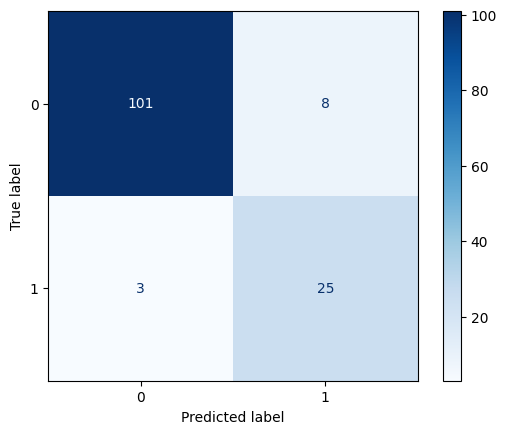

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [9]:
pipeline.score(X_train, y_train)

0.8956043956043956